In [47]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pydicom
import cv2
import pickle
from models.efficient_net import ImprovedEfficientNet
from config import Config

def load_data():
    """Load validation data"""
    try:
        # Load bounding box data
        df = pd.read_csv('lung_bbox.csv')
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files - using the train data pickle paths
        with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
            series_list = pickle.load(f)
        with open('process_input/splitall/series_dict.pickle', 'rb') as f:
            series_dict = pickle.load(f)
        with open('process_input/splitall/image_dict.pickle', 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        print(f"Loaded {len(image_dict)} total images")
        print(f"Loaded {len(bbox_dict)} bounding boxes")

        return bbox_dict, series_list_valid, series_dict, image_dict
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        # Print the current working directory to help with path debugging
        print(f"Current working directory: {os.getcwd()}")
        raise

# Let's also add a function to check all required files exist
def check_data_files():
    required_files = [
        'lung_bbox.csv',
        'process_input/splitall/series_list_train.pickle',
        'process_input/splitall/series_dict.pickle',
        'process_input/splitall/image_dict.pickle'
    ]
    
    missing_files = []
    for file_path in required_files:
        if not os.path.exists(file_path):
            missing_files.append(file_path)
    
    if missing_files:
        print("Missing required files:")
        for file_path in missing_files:
            print(f"- {file_path}")
        return False
    
    print("All required files found!")
    return True

# First check if files exist
if check_data_files():
    # Then load the data
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    
    # Create validation dataset
    image_list_valid = create_validation_data(series_list_valid, series_dict)
    print(f'Number of validation images: {len(image_list_valid)}')
else:
    print("Please ensure all required files exist before proceeding.")

def create_validation_data(series_list_valid, series_dict):
    """Create validation dataset"""
    image_list_valid = []
    for series_id in series_list_valid:
        sorted_image_list = series_dict[series_id]['sorted_image_list']
        num_image = len(sorted_image_list)
        selected_idx = [
            int(0.2*num_image), int(0.3*num_image),
            int(0.4*num_image), int(0.5*num_image)
        ]
        image_list_valid.extend([sorted_image_list[i] for i in selected_idx])
    return image_list_valid

def load_model(checkpoint_path):
    """Load trained model"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3').to(device)
        print("Model initialized")
        
        # Load checkpoint
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print("Checkpoint loaded")
        
        # Handle different checkpoint formats
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                print("Loaded model from state dict")
            elif 'state_dict' in checkpoint:
                model.load_state_dict(checkpoint['state_dict'])
                print("Loaded model from state dict")
            else:
                print("Loading full checkpoint directly")
                model.load_state_dict(checkpoint)
        else:
            print("Loading checkpoint directly")
            model.load_state_dict(checkpoint)
        
        model.eval()
        return model, device
    
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print(f"Checkpoint path: {checkpoint_path}")
        if os.path.exists(checkpoint_path):
            print(f"File size: {os.path.getsize(checkpoint_path)} bytes")
        else:
            print("Checkpoint file does not exist!")
        raise

# Try loading the model with different checkpoint names
def find_latest_checkpoint():
    """Find the latest checkpoint in weights directory"""
    if not os.path.exists('weights'):
        print("Weights directory not found!")
        return None
    
    checkpoints = []
    for f in os.listdir('weights'):
        if f.endswith('.pth'):
            try:
                epoch = int(''.join(filter(str.isdigit, f)))
                checkpoints.append((epoch, f))
            except:
                continue
    
    if not checkpoints:
        print("No checkpoints found!")
        return None
    
    latest = max(checkpoints, key=lambda x: x[0])
    return os.path.join('weights', latest[1])

# Try loading the model
try:
    checkpoint_path = find_latest_checkpoint()
    if checkpoint_path is None:
        print("Please specify the correct checkpoint path!")
    else:
        print(f"Found latest checkpoint: {checkpoint_path}")
        model, device = load_model(checkpoint_path)
        print("Model loaded successfully!")
        
        # Continue with evaluation
        results, ious = evaluate_model(model, image_list_valid, image_dict, bbox_dict)
        
        # Plot results
        plot_iou_distribution(ious)
        visualize_predictions(results, image_dict)
        analyze_position_performance(results, image_dict)
except Exception as e:
    print(f"Error in model loading or evaluation: {str(e)}")
    print("\nAvailable files in weights directory:")
    if os.path.exists('weights'):
        print(os.listdir('weights'))
    else:
        print("weights directory not found!")

# Utility Functions
def draw_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    """Draw bounding box on image"""
    h, w = image.shape[:2]
    x1, y1, x2, y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                      for i, coord in enumerate(bbox)]
    return cv2.rectangle(image.copy(), (x1, y1), (x2, y2), color, thickness)

def compute_iou(bbox1, bbox2):
    """Compute IoU between two bounding boxes"""
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = bbox1_area + bbox2_area - intersection
    return intersection / (union + 1e-6)


# Model Evaluation
def evaluate_model(model, image_list, image_dict, bbox_dict):
    """Evaluate model on validation set"""
    results = []
    ious = []
    
    for image_id in tqdm(image_list):
        # Load image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm'
        
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        
        # Preprocess image
        image = (image - image.min()) / (image.max() - image.min())
        image = cv2.resize(image, (Config.image_size, Config.image_size))
        image = np.stack([image, image, image], axis=2)
        
        # Get model prediction
        x = torch.from_numpy(image.transpose(2, 0, 1)).float()
        x = x.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred_bbox = model(x).cpu().numpy()[0]
        
        # Calculate IoU
        gt_bbox = bbox_dict[image_id]
        iou = compute_iou(pred_bbox, gt_bbox)
        
        results.append({
            'image_id': image_id,
            'gt_bbox': gt_bbox,
            'pred_bbox': pred_bbox,
            'iou': iou
        })
        ious.append(iou)
    
    return results, np.array(ious)


# Visualization Functions
def visualize_predictions(results, image_dict, num_samples=5):
    """Visualize model predictions"""
    indices = np.random.choice(len(results), num_samples, replace=False)
    
    plt.figure(figsize=(20, 4*num_samples))
    for i, idx in enumerate(indices):
        result = results[idx]
        image_id = result['image_id']
        
        # Load image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm'
        
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        image = (image - image.min()) / (image.max() - image.min())
        image = (image * 255).astype(np.uint8)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # Draw bounding boxes
        image_gt = draw_bbox(image, result['gt_bbox'], (0, 255, 0), 2)
        image_pred = draw_bbox(image_gt, result['pred_bbox'], (255, 0, 0), 2)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image_pred)
        plt.title(f'Image ID: {image_id}, IoU: {result["iou"]:.3f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_position_performance(results, image_dict):
    """Analyze performance by position in series"""
    positions = []
    for result in results:
        image_id = result['image_id']
        total_images = image_dict[image_id]['total_images']
        image_index = image_dict[image_id]['image_index']
        relative_position = image_index / total_images
        positions.append({
            'relative_position': relative_position,
            'iou': result['iou']
        })
    
    df = pd.DataFrame(positions)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='relative_position', y='iou', alpha=0.5)
    sns.regplot(data=df, x='relative_position', y='iou', scatter=False, color='red')
    plt.title('IoU vs Relative Position in Series')
    plt.xlabel('Relative Position')
    plt.ylabel('IoU')
    plt.show()

def plot_iou_distribution(ious):
    """Plot IoU score distribution"""
    plt.figure(figsize=(10, 6))
    sns.histplot(ious, bins=50)
    plt.title('Distribution of IoU Scores')
    plt.xlabel('IoU')
    plt.ylabel('Count')
    plt.axvline(ious.mean(), color='r', linestyle='--', 
                label=f'Mean IoU: {ious.mean():.3f}')
    plt.legend()
    plt.show()
    
    print(f'Mean IoU: {ious.mean():.3f}')
    print(f'Median IoU: {np.median(ious):.3f}')
    print(f'Std IoU: {ious.std():.3f}')


def export_results(results, output_path='validation_results.csv'):
    """Export results to CSV"""
    df = pd.DataFrame([{
        'image_id': r['image_id'],
        'gt_x1': r['gt_bbox'][0],
        'gt_y1': r['gt_bbox'][1],
        'gt_x2': r['gt_bbox'][2],
        'gt_y2': r['gt_bbox'][3],
        'pred_x1': r['pred_bbox'][0],
        'pred_y1': r['pred_bbox'][1],
        'pred_x2': r['pred_bbox'][2],
        'pred_y2': r['pred_bbox'][3],
        'iou': r['iou']
    } for r in results])
    
    df.to_csv(output_path, index=False)
    print(f'Results saved to {output_path}')

# Load data
bbox_dict, series_list_valid, series_dict, image_dict = load_data()

# Create validation dataset
image_list_valid = create_validation_data(series_list_valid, series_dict)

# Load model
model, device = load_model('weights/model_epoch_40.pth')

# Evaluate model
results, ious = evaluate_model(model, image_list_valid, image_dict, bbox_dict)

# Visualize results
plot_iou_distribution(ious)
visualize_predictions(results, image_dict)
analyze_position_performance(results, image_dict)

# Export results
export_results(results)

All required files found!
Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes
Number of validation images: 4656
Found latest checkpoint: weights/model_epoch_40.pth
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized
Loading checkpoint from: weights/model_epoch_40.pth
Error loading model: "filename 'storages' not found"
Checkpoint path: weights/model_epoch_40.pth
File size: 2994176 bytes
Error in model loading or evaluation: "filename 'storages' not found"

Available files in weights directory:
['model_epoch_35.pth', 'model_epoch_30.pth', '.ipynb_checkpoints', 'model_epoch_40.pth', 'model_epoch_25.pth']


/tmp/ipykernel_3908376/880509666.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized
Loading checkpoint from: weights/model_epoch_40.pth
Error loading model: "filename 'storages' not found"
Checkpoint path: weights/model_epoch_40.pth
File size: 2994176 bytes


/tmp/ipykernel_3908376/880509666.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


KeyError: "filename 'storages' not found"

In [40]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pydicom
import cv2
import pickle

# Define paths directly
DATA_PATHS = {
    'bbox_csv': 'lung_bbox.csv',
    'series_dict': 'process_input/splitall/series_dict.pickle',
    'series_list_train': 'process_input/splitall/series_list_train.pickle',
    'image_dict': 'process_input/splitall/image_dict.pickle',
    'train_data': '/storage/scratch2/sandaruwanh/rsna_lg'
}

def load_data():
    """Load validation data"""
    try:
        # Load bounding box data
        df = pd.read_csv(DATA_PATHS['bbox_csv'])
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files
        with open(DATA_PATHS['series_list_train'], 'rb') as f:
            series_list = pickle.load(f)
        with open(DATA_PATHS['series_dict'], 'rb') as f:
            series_dict = pickle.load(f)
        with open(DATA_PATHS['image_dict'], 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        print(f"Loaded {len(image_dict)} total images")
        print(f"Loaded {len(bbox_dict)} bounding boxes")

        return bbox_dict, series_list_valid, series_dict, image_dict
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")
        # Print available files in the process_input/splitall directory
        try:
            print("\nFiles in process_input/splitall:")
            print(os.listdir('process_input/splitall'))
        except:
            print("Could not list directory contents")
        raise

def check_data_files():
    """Check if all required files exist"""
    for name, path in DATA_PATHS.items():
        if not os.path.exists(path):
            print(f"Missing file: {path}")
            return False
    print("All required files found!")
    return True

# First check if files exist
print("Checking data files...")
if check_data_files():
    print("\nLoading data...")
    # Then load the data
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    
    # Create validation dataset
    image_list_valid = create_validation_data(series_list_valid, series_dict)
    print(f'Number of validation images: {len(image_list_valid)}')
else:
    print("Please ensure all required files exist before proceeding.")

Checking data files...
All required files found!

Loading data...
Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes
Number of validation images: 4656


In [43]:
# First, let's check what checkpoints we have
import glob
checkpoints = sorted(glob.glob('weights/*.pth'))
print("\nAvailable checkpoints:")
for cp in checkpoints:
    print(f"- {cp} ({os.path.getsize(cp)/1024/1024:.2f} MB)")

def save_and_load_model_safe(checkpoint_path):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\nUsing device: {device}")
        
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3')
        print("Model initialized")
        
        # Load and immediately save in a simple format
        temp_path = 'weights/temp_checkpoint.pth'
        state_dict = {}
        
        with open(checkpoint_path, 'rb') as f:
            checkpoint = torch.load(f, map_location='cpu')
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                else:
                    state_dict = checkpoint
            else:
                state_dict = checkpoint
        
        # Save clean state dict
        torch.save(state_dict, temp_path)
        print(f"Saved clean checkpoint")
        
        # Load the clean checkpoint
        model.load_state_dict(torch.load(temp_path))
        model = model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Clean up
        if os.path.exists(temp_path):
            os.remove(temp_path)
            
        return model, device
    
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None

# Try loading the latest checkpoint
checkpoint_path = 'weights/model_epoch_40.pth'  # or whichever checkpoint you want to use
model, device = save_and_load_model_safe(checkpoint_path)

if model is not None:
    print("\nStarting evaluation...")
    with torch.no_grad():  # Add this for inference
        results, ious = evaluate_model(model, image_list_valid, image_dict, bbox_dict)
    
    # Print summary statistics
    print("\nPerformance Summary:")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Std IoU: {np.std(ious):.3f}")
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(ious, bins=50)
    plt.title('Distribution of IoU Scores')
    plt.xlabel('IoU')
    plt.ylabel('Count')
    plt.axvline(np.mean(ious), color='r', linestyle='--', 
                label=f'Mean IoU: {np.mean(ious):.3f}')
    plt.legend()
    plt.show()
    
    # Visualize some predictions
    print("\nVisualizing random samples...")
    visualize_predictions(results, num_samples=5)
    
    # Save results
    print("\nSaving results...")
    results_df = pd.DataFrame([
        {
            'image_id': r['image_id'],
            'iou': r['iou'],
            'pred_x1': r['pred_bbox'][0],
            'pred_y1': r['pred_bbox'][1],
            'pred_x2': r['pred_bbox'][2],
            'pred_y2': r['pred_bbox'][3],
            'gt_x1': r['gt_bbox'][0],
            'gt_y1': r['gt_bbox'][1],
            'gt_x2': r['gt_bbox'][2],
            'gt_y2': r['gt_bbox'][3]
        }
        for r in results
    ])
    
    results_df.to_csv('evaluation_results.csv', index=False)
    print("Results saved to evaluation_results.csv")
else:
    print("Failed to load model. Please check the checkpoint file.")


Available checkpoints:
- weights/model_epoch_25.pth (106.42 MB)
- weights/model_epoch_30.pth (0.54 MB)
- weights/model_epoch_35.pth (0.00 MB)
- weights/model_epoch_40.pth (2.86 MB)

Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized
Error loading model: "filename 'storages' not found"
Failed to load model. Please check the checkpoint file.


/tmp/ipykernel_3908376/3141284430.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f, map_location='cpu')


In [45]:
def save_clean_checkpoint(model, path):
    """Save model in a clean format"""
    try:
        # Get state dict
        if hasattr(model, 'module'):
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
            
        # Save with torch.save
        torch.save(state_dict, path)
        print(f"Saved clean checkpoint to: {path}")
        
        # Verify the save worked
        loaded = torch.load(path, map_location='cpu')
        print("Verified checkpoint can be loaded")
        
        return True
    except Exception as e:
        print(f"Error saving checkpoint: {str(e)}")
        return False

# Save current model in clean format
if model is not None:
    save_clean_checkpoint(model, 'weights/model_epoch_40.pth')

In [50]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pydicom
import cv2
import pickle
from models.efficient_net import ImprovedEfficientNet
import torch.nn as nn

# Configuration
class Config:
    image_size = 512
    model_name = 'efficientnet-b3'
    train_data_dir = '../../../input/train/'  # Update this path
    
# Model definition
class ImprovedEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet-b3'):
        super().__init__()
        from efficientnet_pytorch import EfficientNet
        self.net = EfficientNet.from_pretrained(model_name)
        in_features = self.net._fc.in_features
        self.last_linear = nn.Sequential(
            nn.Linear(in_features, in_features//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features//2, 4)
        )
        
    def forward(self, x):
        x = self.net.extract_features(x)
        x = self.net._avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

# Data Loading Functions
def load_data():
    try:
        # Load bounding box data
        df = pd.read_csv('lung_bbox.csv')
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files
        with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
            series_list = pickle.load(f)
        with open('process_input/splitall/series_dict.pickle', 'rb') as f:
            series_dict = pickle.load(f)
        with open('process_input/splitall/image_dict.pickle', 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        print(f"Loaded {len(image_dict)} total images")
        print(f"Loaded {len(bbox_dict)} bounding boxes")

        return bbox_dict, series_list_valid, series_dict, image_dict
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def create_validation_data(series_list_valid, series_dict):
    image_list_valid = []
    for series_id in series_list_valid:
        sorted_image_list = series_dict[series_id]['sorted_image_list']
        num_image = len(sorted_image_list)
        selected_idx = [
            int(0.2*num_image), int(0.3*num_image),
            int(0.4*num_image), int(0.5*num_image)
        ]
        image_list_valid.extend([sorted_image_list[i] for i in selected_idx])
    return image_list_valid

# Model Loading
def load_model_safe(checkpoint_path):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ImprovedEfficientNet(Config.model_name)
        
        # Create a clean state dict
        state_dict = {}
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            elif 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            else:
                state_dict = checkpoint
        else:
            state_dict = checkpoint
            
        # Save and reload the state dict
        temp_path = 'temp_checkpoint.pth'
        torch.save(state_dict, temp_path)
        model.load_state_dict(torch.load(temp_path))
        os.remove(temp_path)
        
        model = model.to(device)
        model.eval()
        print("Model loaded successfully")
        return model, device
        
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Evaluation Functions
def draw_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    h, w = image.shape[:2]
    x1, y1, x2, y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                      for i, coord in enumerate(bbox)]
    return cv2.rectangle(image.copy(), (x1, y1), (x2, y2), color, thickness)

def compute_iou(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = bbox1_area + bbox2_area - intersection
    return intersection / (union + 1e-6)

def evaluate_model(model, device, image_list, image_dict, bbox_dict):
    results = []
    ious = []
    
    for image_id in tqdm(image_list):
        # Load image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
        
        try:
            data = pydicom.dcmread(dcm_path)
            image = data.pixel_array.astype(np.float32)
            image = image * data.RescaleSlope + data.RescaleIntercept
            
            # Preprocess
            image = (image - image.min()) / (image.max() - image.min())
            image = cv2.resize(image, (Config.image_size, Config.image_size))
            image = np.stack([image, image, image], axis=2)
            
            # Predict
            x = torch.from_numpy(image.transpose(2, 0, 1)).float()
            x = x.unsqueeze(0).to(device)
            
            with torch.no_grad():
                pred_bbox = model(x).cpu().numpy()[0]
            
            # Calculate IoU
            gt_bbox = bbox_dict[image_id]
            iou = compute_iou(pred_bbox, gt_bbox)
            
            results.append({
                'image_id': image_id,
                'gt_bbox': gt_bbox,
                'pred_bbox': pred_bbox,
                'iou': iou
            })
            ious.append(iou)
            
        except Exception as e:
            print(f"Error processing image {image_id}: {e}")
            continue
    
    return results, np.array(ious)

# Visualization Functions
def visualize_results(results, image_dict, num_samples=5):
    indices = np.random.choice(len(results), num_samples, replace=False)
    plt.figure(figsize=(20, 4*num_samples))
    
    for i, idx in enumerate(indices):
        result = results[idx]
        image_id = result['image_id']
        
        # Load and process image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
        
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        image = (image - image.min()) / (image.max() - image.min())
        image = (image * 255).astype(np.uint8)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # Draw predictions
        image_gt = draw_bbox(image, result['gt_bbox'], (0, 255, 0), 2)
        image_pred = draw_bbox(image_gt, result['pred_bbox'], (255, 0, 0), 2)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image_pred)
        plt.title(f'Image ID: {image_id}, IoU: {result["iou"]:.3f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    # Set up without custom style
    os.makedirs('results', exist_ok=True)
    
    # Set default plotting style
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.dpi'] = 100
    
    print("Loading data...")
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    image_list_valid = create_validation_data(series_list_valid, series_dict)
    print(f"Validation set size: {len(image_list_valid)} images")
    
    print("\nLoading model...")
    model, device = load_model_safe('weights/model_epoch_40.pth')
    
    print("\nEvaluating model...")
    results, ious = evaluate_model(model, device, image_list_valid, image_dict, bbox_dict)
    
    print("\nResults:")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Std IoU: {np.std(ious):.3f}")
    
    # Plot IoU distribution
    plt.figure()
    plt.hist(ious, bins=50, edgecolor='black')
    plt.title('Distribution of IoU Scores')
    plt.xlabel('IoU')
    plt.ylabel('Count')
    plt.axvline(np.mean(ious), color='red', linestyle='--', 
                label=f'Mean IoU: {np.mean(ious):.3f}')
    plt.legend()
    plt.savefig('results/iou_distribution.png')
    plt.close()
    
    print("\nVisualizing results...")
    visualize_results(results, image_dict)
    
    # Save results
    results_df = pd.DataFrame([
        {
            'image_id': r['image_id'],
            'iou': r['iou'],
            'pred_x1': r['pred_bbox'][0],
            'pred_y1': r['pred_bbox'][1],
            'pred_x2': r['pred_bbox'][2],
            'pred_y2': r['pred_bbox'][3],
            'gt_x1': r['gt_bbox'][0],
            'gt_y1': r['gt_bbox'][1],
            'gt_x2': r['gt_bbox'][2],
            'gt_y2': r['gt_bbox'][3]
        }
        for r in results
    ])
    results_df.to_csv('results/validation_results.csv', index=False)
    print("\nResults saved to results/validation_results.csv")

if __name__ == "__main__":
    main()

Loading data...
Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes
Validation set size: 4656 images

Loading model...
Loaded pretrained weights for efficientnet-b3
Error loading model: "filename 'storages' not found"


/tmp/ipykernel_3908376/2551144078.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


KeyError: "filename 'storages' not found"

In [63]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pydicom
import cv2
import pickle
import torch.nn as nn
from models.efficient_net import ImprovedEfficientNet

# Configuration
class Config:
    image_size = 512
    model_name = 'efficientnet-b3'
    train_data_dir = '/storage/scratch2/sandaruwanh/rsna_lg' # Update this path
    
# Model definition
class ImprovedEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet-b3'):
        super().__init__()
        from efficientnet_pytorch import EfficientNet
        self.net = EfficientNet.from_pretrained(model_name)
        in_features = self.net._fc.in_features
        self.last_linear = nn.Sequential(
            nn.Linear(in_features, in_features//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features//2, 4)
        )
        
    def forward(self, x):
        x = self.net.extract_features(x)
        x = self.net._avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

# Data Loading Functions
def load_data():
    try:
        # Load bounding box data
        df = pd.read_csv('lung_bbox.csv')
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files
        with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
            series_list = pickle.load(f)
        with open('process_input/splitall/series_dict.pickle', 'rb') as f:
            series_dict = pickle.load(f)
        with open('process_input/splitall/image_dict.pickle', 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        print(f"Loaded {len(image_dict)} total images")
        print(f"Loaded {len(bbox_dict)} bounding boxes")

        return bbox_dict, series_list_valid, series_dict, image_dict
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def create_validation_data(series_list_valid, series_dict):
    image_list_valid = []
    for series_id in series_list_valid:
        sorted_image_list = series_dict[series_id]['sorted_image_list']
        num_image = len(sorted_image_list)
        selected_idx = [
            int(0.2*num_image), int(0.3*num_image),
            int(0.4*num_image), int(0.5*num_image)
        ]
        image_list_valid.extend([sorted_image_list[i] for i in selected_idx])
    return image_list_valid

# Model Loading
def load_model_safe(checkpoint_path):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ImprovedEfficientNet(Config.model_name)
        
        # Create a clean state dict
        state_dict = {}
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            elif 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            else:
                state_dict = checkpoint
        else:
            state_dict = checkpoint
            
        # Save and reload the state dict
        temp_path = 'temp_checkpoint.pth'
        torch.save(state_dict, temp_path)
        model.load_state_dict(torch.load(temp_path))
        os.remove(temp_path)
        
        model = model.to(device)
        model.eval()
        print("Model loaded successfully")
        return model, device
        
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Evaluation Functions
def draw_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    h, w = image.shape[:2]
    x1, y1, x2, y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                      for i, coord in enumerate(bbox)]
    return cv2.rectangle(image.copy(), (x1, y1), (x2, y2), color, thickness)

def compute_iou(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = bbox1_area + bbox2_area - intersection
    return intersection / (union + 1e-6)



def evaluate_model(model, device, image_list, image_dict, bbox_dict):
    results = []
    ious = []
    
    for image_id in tqdm(image_list):
        # Load image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
        
        try:
            data = pydicom.dcmread(dcm_path)
            image = data.pixel_array.astype(np.float32)
            image = image * data.RescaleSlope + data.RescaleIntercept
            
            # Preprocess
            image = (image - image.min()) / (image.max() - image.min())
            image = cv2.resize(image, (Config.image_size, Config.image_size))
            image = np.stack([image, image, image], axis=2)
            
            # Predict
            x = torch.from_numpy(image.transpose(2, 0, 1)).float()
            x = x.unsqueeze(0).to(device)
            
            with torch.no_grad():
                pred_bbox = model(x).cpu().numpy()[0]
            
            # Calculate IoU
            gt_bbox = bbox_dict[image_id]
            iou = compute_iou(pred_bbox, gt_bbox)
            
            results.append({
                'image_id': image_id,
                'gt_bbox': gt_bbox,
                'pred_bbox': pred_bbox,
                'iou': iou
            })
            ious.append(iou)
            
        except Exception as e:
            print(f"Error processing image {image_id}: {e}")
            continue
    
    return results, np.array(ious)

# Visualization Functions
def visualize_results(results, image_dict, num_samples=5):
    indices = np.random.choice(len(results), num_samples, replace=False)
    plt.figure(figsize=(20, 4*num_samples))
    
    for i, idx in enumerate(indices):
        result = results[idx]
        image_id = result['image_id']
        
        # Load and process image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
        
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        image = (image - image.min()) / (image.max() - image.min())
        image = (image * 255).astype(np.uint8)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # Draw predictions
        image_gt = draw_bbox(image, result['gt_bbox'], (0, 255, 0), 2)
        image_pred = draw_bbox(image_gt, result['pred_bbox'], (255, 0, 0), 2)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image_pred)
        plt.title(f'Image ID: {image_id}, IoU: {result["iou"]:.3f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def verify_checkpoint(checkpoint_path):
    """Verify checkpoint file"""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return False
    
    print(f"Found checkpoint: {checkpoint_path}")
    print(f"Size: {os.path.getsize(checkpoint_path)/1024/1024:.2f} MB")
    
    try:
        # Read the file in binary mode
        with open(checkpoint_path, 'rb') as f:
            # Try different loading methods
            try:
                checkpoint = torch.load(f, map_location='cpu')
                print("Successfully loaded checkpoint")
                return True
            except RuntimeError:
                # Try loading with different encoding
                f.seek(0)
                checkpoint = torch.load(f, map_location='cpu', encoding='latin1')
                print("Successfully loaded checkpoint with latin1 encoding")
                return True
            except Exception as e:
                print(f"Error loading checkpoint: {str(e)}")
                return False
    except Exception as e:
        print(f"Error opening checkpoint file: {str(e)}")
        return False

def load_model_safe(checkpoint_path):
    """Load model with safety checks"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ImprovedEfficientNet(Config.model_name)
        print("Model initialized")

        # Read checkpoint
        with open(checkpoint_path, 'rb') as f:
            try:
                # Try loading the state dict directly
                state_dict = torch.load(f, map_location='cpu')
                print("Loaded checkpoint")
                
                # Clean state dict if needed
                cleaned_dict = {}
                for k, v in state_dict.items():
                    # Remove 'module.' prefix if present
                    if k.startswith('module.'):
                        cleaned_dict[k[7:]] = v
                    else:
                        cleaned_dict[k] = v
                
                # Try loading the cleaned state dict
                model.load_state_dict(cleaned_dict)
                print("Successfully loaded state dict")
                
            except Exception as e:
                print(f"Error in first attempt: {str(e)}")
                # Try alternative loading method
                f.seek(0)
                try:
                    state_dict = torch.load(f, map_location='cpu', encoding='latin1')
                    model.load_state_dict(state_dict)
                    print("Successfully loaded with alternative method")
                except Exception as e:
                    print(f"Error in alternative attempt: {str(e)}")
                    raise

        model = model.to(device)
        model.eval()
        print(f"Model moved to {device}")
        return model, device

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

def save_clean_checkpoint(model, path):
    """Save model in a clean format"""
    try:
        # Get state dict
        if hasattr(model, 'module'):
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
            
        # Save with torch.save
        torch.save(state_dict, path)
        print(f"Saved clean checkpoint to: {path}")
        return True
    except Exception as e:
        print(f"Error saving checkpoint: {str(e)}")
        return False
        
def main():
    try:
        # Set up basic plotting style
        plt.rcParams['figure.figsize'] = (12, 8)
        plt.rcParams['axes.grid'] = True
        plt.rcParams['figure.dpi'] = 100
        
        # Create results directory
        os.makedirs('results', exist_ok=True)
        
        print("Loading data...")
        bbox_dict, series_list_valid, series_dict, image_dict = load_data()
        image_list_valid = create_validation_data(series_list_valid, series_dict)
        print(f"Validation set size: {len(image_list_valid)} images")
        
        print("\nVerifying checkpoint...")
        checkpoint_path = 'weights/model_epoch_40.pth'

        checkpoints_to_try = [
            'weights/model_epoch_40.pth',
            'weights/model_epoch_35.pth',
            'weights/model_epoch_30.pth',
            'weights/model_epoch_25.pth'
        ]

        model = None
        for cp_path in checkpoints_to_try:
            if os.path.exists(cp_path):
                print(f"\nTrying checkpoint: {cp_path}")
                try:
                    model, device = load_model_safe(cp_path)
                    if model is not None:
                        print(f"Successfully loaded checkpoint: {cp_path}")
                        break
                except Exception as e:
                    print(f"Failed to load {cp_path}: {str(e)}")
        
        if model is None:
            raise ValueError("Failed to load any checkpoint")
        
        if verify_checkpoint(checkpoint_path):
            print("\nLoading model...")
            model, device = load_model_safe(checkpoint_path)
        else:
            raise ValueError("Failed to verify checkpoint")
        
        print("\nEvaluating model...")
        results, ious = evaluate_model(model, device, image_list_valid, image_dict, bbox_dict)
        
        print("\nResults:")
        print(f"Mean IoU: {np.mean(ious):.3f}")
        print(f"Median IoU: {np.median(ious):.3f}")
        print(f"Std IoU: {np.std(ious):.3f}")
        
        # Plot IoU distribution
        plt.figure()
        plt.hist(ious, bins=50, color='skyblue', edgecolor='black')
        plt.title('Distribution of IoU Scores', fontsize=12)
        plt.xlabel('IoU', fontsize=10)
        plt.ylabel('Count', fontsize=10)
        plt.axvline(np.mean(ious), color='red', linestyle='--', 
                   label=f'Mean IoU: {np.mean(ious):.3f}')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.savefig('results/iou_distribution.png')
        plt.close()
        
        print("\nVisualizing sample predictions...")
        visualize_results(results, image_dict, num_samples=5)
        
        # Save results to CSV
        results_df = pd.DataFrame([
            {
                'image_id': r['image_id'],
                'iou': r['iou'],
                'pred_x1': r['pred_bbox'][0],
                'pred_y1': r['pred_bbox'][1],
                'pred_x2': r['pred_bbox'][2],
                'pred_y2': r['pred_bbox'][3],
                'gt_x1': r['gt_bbox'][0],
                'gt_y1': r['gt_bbox'][1],
                'gt_x2': r['gt_bbox'][2],
                'gt_y2': r['gt_bbox'][3]
            }
            for r in results
        ])
        
        results_df.to_csv('results/validation_results.csv', index=False)
        print("\nResults saved to results/validation_results.csv")
        
    except Exception as e:
        print(f"\nError in main: {str(e)}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()

Loading data...
Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes
Validation set size: 4656 images

Verifying checkpoint...

Trying checkpoint: weights/model_epoch_40.pth
Loaded pretrained weights for efficientnet-b3
Model initialized


/tmp/ipykernel_3908376/241627380.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location='cpu')
/tmp/ipykernel_3908376/241627380.py:282

Error in first attempt: "filename 'storages' not found"
Error in alternative attempt: "filename 'storages' not found"
Error loading model: "filename 'storages' not found"
Failed to load weights/model_epoch_40.pth: "filename 'storages' not found"

Trying checkpoint: weights/model_epoch_35.pth
Loaded pretrained weights for efficientnet-b3
Model initialized
Error in first attempt: PytorchStreamReader failed reading zip archive: failed finding central directory
Error in alternative attempt: PytorchStreamReader failed reading zip archive: failed finding central directory
Error loading model: PytorchStreamReader failed reading zip archive: failed finding central directory
Failed to load weights/model_epoch_35.pth: PytorchStreamReader failed reading zip archive: failed finding central directory

Trying checkpoint: weights/model_epoch_30.pth
Loaded pretrained weights for efficientnet-b3
Model initialized
Error in first attempt: PytorchStreamReader failed reading zip archive: failed finding cen

In [62]:
def examine_checkpoint(checkpoint_path):
    """Examine the contents of a checkpoint file"""
    print(f"\nExamining checkpoint: {checkpoint_path}")
    print(f"File exists: {os.path.exists(checkpoint_path)}")
    print(f"File size: {os.path.getsize(checkpoint_path)/1024/1024:.2f} MB")
    
    try:
        # Try reading as binary
        with open(checkpoint_path, 'rb') as f:
            # Read first few bytes
            header = f.read(100)
            print("\nFile header (hex):")
            print(header.hex()[:100])
            
        # Try different loading methods
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            print("\nSuccessfully loaded with default method")
            if isinstance(checkpoint, dict):
                print("Keys:", checkpoint.keys())
            else:
                print("Type:", type(checkpoint))
        except Exception as e:
            print(f"\nError with default loading: {str(e)}")
            
            try:
                checkpoint = torch.load(checkpoint_path, map_location='cpu', encoding='latin1')
                print("\nSuccessfully loaded with latin1 encoding")
                if isinstance(checkpoint, dict):
                    print("Keys:", checkpoint.keys())
                else:
                    print("Type:", type(checkpoint))
            except Exception as e:
                print(f"\nError with latin1 loading: {str(e)}")
    
    except Exception as e:
        print(f"\nError examining checkpoint: {str(e)}")

# Add this to your main function:
print("\nExamining checkpoint file...")
examine_checkpoint('weights/model_epoch_40.pth')


Examining checkpoint file...

Examining checkpoint: weights/model_epoch_40.pth
File exists: True
File size: 2.86 MB

File header (hex):
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Error with default loading: "filename 'storages' not found"

Error with latin1 loading: "filename 'storages' not found"


/tmp/ipykernel_3908376/2300478799.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')
/tmp/ipykernel_3908376/23

In [64]:
def list_checkpoints():
    if not os.path.exists('weights'):
        print("weights directory not found")
        return
    
    print("Available checkpoints:")
    for f in os.listdir('weights'):
        if f.endswith('.pth'):
            path = os.path.join('weights', f)
            print(f"- {f}: {os.path.getsize(path)/1024/1024:.2f} MB")

list_checkpoints()

Available checkpoints:
- model_epoch_35.pth: 0.00 MB
- model_epoch_30.pth: 0.54 MB
- model_epoch_40.pth: 2.86 MB
- model_epoch_25.pth: 106.42 MB


In [67]:
def load_model_simple(checkpoint_path):
    """Load model in the simplest possible way"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3')
        print("Model initialized")
        
        # Load the checkpoint file in binary mode
        with open(checkpoint_path, 'rb') as f:
            # Read the entire file
            data = f.read()
            
            # Save it in a simple format
            simple_path = 'weights/simple_checkpoint.pth'
            with open(simple_path, 'wb') as f2:
                f2.write(data)
            
            # Try to load it
            try:
                state_dict = torch.load(simple_path, map_location=device)
                model.load_state_dict(state_dict)
                print("Loaded checkpoint successfully")
            except:
                print("Failed to load checkpoint directly")
                
                # Try loading as zip
                import zipfile
                try:
                    with zipfile.ZipFile(checkpoint_path) as z:
                        print("Checkpoint contents:", z.namelist())
                except:
                    print("Not a valid zip file")
        
        model = model.to(device)
        model.eval()
        return model, device
        
    except Exception as e:
        print(f"Error in load_model_simple: {str(e)}")
        return None, None

# Try loading with simple method
print("\nTrying simple loading method...")
model, device = load_model_simple('weights/model_epoch_40.pth')

if model is not None:
    # Save in a clean format
    try:
        state_dict = model.state_dict()
        torch.save(state_dict, 'weights/clean_checkpoint.pth')
        print("Saved clean checkpoint")
    except Exception as e:
        print(f"Error saving clean checkpoint: {str(e)}")


Trying simple loading method...
Loaded pretrained weights for efficientnet-b3
Model initialized


/tmp/ipykernel_3908376/469094646.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(simple_path, map_location=device)


Failed to load checkpoint directly
Not a valid zip file
Saved clean checkpoint


In [68]:
# Check file contents
with open('weights/model_epoch_40.pth', 'rb') as f:
    data = f.read(100)  # Read first 100 bytes
    print("File header (hex):")
    print(data.hex())

File header (hex):
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [69]:
def load_model_simple(checkpoint_path):
    """Load model in the simplest possible way"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3')
        print("Model initialized")
        
        # Try direct loading
        try:
            # Load state dict with pickle5 backend
            import pickle5 as pickle
            with open(checkpoint_path, 'rb') as f:
                state_dict = pickle.load(f)
            print("Loaded state dict with pickle5")
            
            # Clean state dict if needed
            cleaned_dict = {}
            for k, v in state_dict.items():
                if k.startswith('module.'):
                    cleaned_dict[k[7:]] = v
                else:
                    cleaned_dict[k] = v
            
            model.load_state_dict(cleaned_dict)
            print("Successfully loaded state dict")
            
        except Exception as e:
            print(f"Failed direct loading: {str(e)}")
            
            # Try alternative loading method
            try:
                state_dict = torch.load(checkpoint_path, map_location='cpu', pickle_module=pickle)
                model.load_state_dict(state_dict)
                print("Loaded with alternative method")
            except Exception as e:
                print(f"Failed alternative loading: {str(e)}")
                return None, None
        
        model = model.to(device)
        model.eval()
        print("Model moved to device and set to eval mode")
        return model, device
        
    except Exception as e:
        print(f"Error in load_model_simple: {str(e)}")
        return None, None

def check_checkpoint_content(checkpoint_path):
    """Check the content of the checkpoint file"""
    try:
        print(f"\nExamining checkpoint: {checkpoint_path}")
        print(f"File size: {os.path.getsize(checkpoint_path)/1024/1024:.2f} MB")
        
        with open(checkpoint_path, 'rb') as f:
            # Read first few bytes to check format
            header = f.read(8)
            print("\nFirst 8 bytes (hex):", header.hex())
            
            # Read full content
            f.seek(0)
            content = f.read()
            print(f"Full file size: {len(content)} bytes")
            
            # Try to identify format
            if content.startswith(b'PK\x03\x04'):
                print("File appears to be a ZIP archive")
            elif content.startswith(b'\x80\x02'):
                print("File appears to be a Pickle protocol 2 file")
            elif content.startswith(b'\x80\x03'):
                print("File appears to be a Pickle protocol 3 file")
            elif content.startswith(b'\x80\x04'):
                print("File appears to be a Pickle protocol 4 file")
            elif content.startswith(b'\x80\x05'):
                print("File appears to be a Pickle protocol 5 file")
            else:
                print("Unknown file format")
            
        return True
    except Exception as e:
        print(f"Error checking checkpoint: {str(e)}")
        return False

# First check the checkpoint content
check_checkpoint_content('weights/model_epoch_40.pth')

# Then try loading
print("\nTrying to load model...")
model, device = load_model_simple('weights/model_epoch_40.pth')

if model is not None:
    print("\nModel loaded successfully!")
    # Try saving in a clean format
    try:
        clean_state_dict = model.state_dict()
        torch.save(clean_state_dict, 'weights/clean_model.pth', _use_new_zipfile_serialization=False)
        print("Saved clean checkpoint")
    except Exception as e:
        print(f"Error saving clean checkpoint: {str(e)}")
else:
    print("\nFailed to load model")


Examining checkpoint: weights/model_epoch_40.pth
File size: 2.86 MB

First 8 bytes (hex): 0000000000000000
Full file size: 2994176 bytes
Unknown file format

Trying to load model...
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized
Failed direct loading: No module named 'pickle5'
Failed alternative loading: cannot access local variable 'pickle' where it is not associated with a value

Failed to load model


In [70]:
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 438.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [176 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-312
      creating build/lib.linux-x86_64-cpython-312/pickle5
      copying pickle5/pickletools.py -> build/lib.linux-x86_64-cpython-312/pickle5
      copying pickle5/pickle.py -> build/lib.linux-x86_64-cpython-312/pickle5
      copying pickle5/__init__.py -> build/lib.linux-x86_64-cpython-312/pickle5
      creating build/lib.linux-x86_64-cpython-312/pickle5/test
      copying pickle5/test/test_pickle.py -> build/lib.linux-x86_64-cpython-312/pickle5/test
      copying pickle5/test/test_picklebuffer.py -> build/lib.linux-x86_64-cpython-312/pickle5/test
      copying pickle5/test/pick

In [71]:
def check_checkpoint_files():
    """Check all checkpoint files in weights directory"""
    if not os.path.exists('weights'):
        print("weights directory not found")
        return
    
    print("Checking checkpoints in weights directory:")
    for filename in os.listdir('weights'):
        if filename.endswith('.pth'):
            path = os.path.join('weights', filename)
            size = os.path.getsize(path)
            print(f"\nCheckpoint: {filename}")
            print(f"Size: {size/1024/1024:.2f} MB")
            
            # Read first 100 bytes
            with open(path, 'rb') as f:
                header = f.read(100)
                if all(b == 0 for b in header):
                    print("WARNING: File appears to be empty or corrupted (all zeros)")
                else:
                    print("Header (hex):", header.hex()[:100])
                    
                # Check if file is non-empty
                f.seek(0, 2)  # Seek to end
                if f.tell() == 0:
                    print("WARNING: File is empty")

# Check all checkpoint files
print("Checking all checkpoint files...")
check_checkpoint_files()

Checking all checkpoint files...
Checking checkpoints in weights directory:

Checkpoint: model_epoch_35.pth
Size: 0.00 MB
Header (hex): 504b03040000080800000000000000000000000000000000000017000b006d6f64656c5f65706f63685f33352f646174612e

Checkpoint: model_epoch_30.pth
Size: 0.54 MB
Header (hex): 504b03040000080800000000000000000000000000000000000017000b006d6f64656c5f65706f63685f33302f646174612e

Checkpoint: clean_checkpoint.pth
Size: 51.71 MB
Header (hex): 504b03040000080800000000000000000000000000000000000019000900636c65616e5f636865636b706f696e742f646174

Checkpoint: model_epoch_40.pth
Size: 2.86 MB

Checkpoint: simple_checkpoint.pth
Size: 2.86 MB

Checkpoint: model_epoch_25.pth
Size: 106.42 MB
Header (hex): 504b03040000080800000000000000000000000000000000000017000b006d6f64656c5f65706f63685f32352f646174612e


In [72]:
def create_new_model():
    """Create and save a new model"""
    try:
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3')
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        model.eval()
        
        # Save in multiple formats to ensure we have a working one
        print("\nSaving model in multiple formats...")
        
        # Format 1: Simple state dict
        torch.save(model.state_dict(), 
                  'weights/new_model_state_dict.pth', 
                  _use_new_zipfile_serialization=False)
        
        # Format 2: Full checkpoint
        torch.save({
            'epoch': 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': None,
            'loss': None,
        }, 'weights/new_model_full.pth', 
        _use_new_zipfile_serialization=False)
        
        print("Saved new model checkpoints")
        return model, device
        
    except Exception as e:
        print(f"Error creating new model: {str(e)}")
        return None, None

# Create new model if checkpoints are corrupted
print("\nCreating new model...")
model, device = create_new_model()


Creating new model...
Loaded pretrained weights for efficientnet-b3

Saving model in multiple formats...
Saved new model checkpoints


In [73]:
def load_pretrained_model():
    """Load pretrained model from PyTorch's model zoo"""
    try:
        from efficientnet_pytorch import EfficientNet
        
        # Load base model
        model = EfficientNet.from_pretrained('efficientnet-b3')
        
        # Modify for our task
        in_features = model._fc.in_features
        model._fc = torch.nn.Linear(in_features, 4)  # 4 outputs for bbox
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        model.eval()
        
        # Save this model
        torch.save(model.state_dict(), 
                  'weights/pretrained_model.pth',
                  _use_new_zipfile_serialization=False)
        
        print("Saved pretrained model")
        return model, device
        
    except Exception as e:
        print(f"Error loading pretrained model: {str(e)}")
        return None, None

# Try loading pretrained model
print("\nTrying to load pretrained model...")
model, device = load_pretrained_model()



Trying to load pretrained model...
Loaded pretrained weights for efficientnet-b3
Saved pretrained model


In [74]:
def load_model_simple(checkpoint_path):
    """Load model in the simplest possible way"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3')
        print("Model initialized")
        
        # Read file content
        with open(checkpoint_path, 'rb') as f:
            try:
                # Try loading with different options
                state_dict = torch.load(checkpoint_path, map_location='cpu', pickle_module=pickle)
                print("Loaded state dict directly")
            except:
                try:
                    # Try loading with different encoding
                    state_dict = torch.load(checkpoint_path, map_location='cpu', encoding='latin1')
                    print("Loaded state dict with latin1 encoding")
                except:
                    try:
                        # Try loading raw file content
                        content = f.read()
                        temp_path = 'weights/temp.pth'
                        with open(temp_path, 'wb') as f2:
                            f2.write(content)
                        state_dict = torch.load(temp_path, map_location='cpu')
                        os.remove(temp_path)
                        print("Loaded state dict from temp file")
                    except Exception as e:
                        print(f"All loading attempts failed: {str(e)}")
                        return None, None
        
        # Try to load state dict
        try:
            # Clean state dict if needed
            cleaned_dict = {}
            for k, v in state_dict.items():
                if k.startswith('module.'):
                    cleaned_dict[k[7:]] = v  # Remove 'module.' prefix
                else:
                    cleaned_dict[k] = v
            
            model.load_state_dict(cleaned_dict)
            print("Successfully loaded state dict")
            
            model = model.to(device)
            model.eval()
            print("Model moved to device and set to eval mode")
            return model, device
            
        except Exception as e:
            print(f"Error loading state dict: {str(e)}")
            return None, None
        
    except Exception as e:
        print(f"Error in load_model_simple: {str(e)}")
        return None, None

def save_model_clean(model, path):
    """Save model in a clean format"""
    try:
        if hasattr(model, 'module'):
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
            
        torch.save(state_dict, path, _use_new_zipfile_serialization=False)
        print(f"Saved clean model to {path}")
        return True
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        return False

# Try loading and saving in clean format
print("\nAttempting to load and clean checkpoint...")
model, device = load_model_simple('weights/model_epoch_40.pth')

if model is not None:
    print("\nSaving in clean format...")
    save_model_clean(model, 'weights/clean_model.pth')
else:
    print("\nFailed to load model. Creating new one...")
    model = ImprovedEfficientNet('efficientnet-b3')
    model = model.to(device)
    model.eval()
    save_model_clean(model, 'weights/new_model.pth')

# Verify the model structure
if model is not None:
    print("\nModel structure:")
    print(model)
    
    # Print model parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")
    
    # Try a forward pass
    try:
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 512, 512).to(device)
            output = model(dummy_input)
            print(f"\nOutput shape: {output.shape}")
    except Exception as e:
        print(f"Error in forward pass: {str(e)}")


Attempting to load and clean checkpoint...
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized


/tmp/ipykernel_3908376/3121158413.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu', encoding='latin1')
/tmp/i

All loading attempts failed: "filename 'storages' not found"

Failed to load model. Creating new one...
Loaded pretrained weights for efficientnet-b3
Saved clean model to weights/new_model.pth

Model structure:
ImprovedEfficientNet(
  (net): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding):

In [ ]:
def evaluate_model(model, image_list_valid, image_dict, bbox_dict, device):
    """Evaluate model on validation set"""
    print("\nStarting evaluation...")
    model.eval()
    results = []
    ious = []
    
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Load image
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm'
                
                # Read and preprocess image
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                image = (image - image.min()) / (image.max() - image.min())
                image = cv2.resize(image, (Config.image_size, Config.image_size))
                image = np.stack([image, image, image], axis=2)
                
                # Convert to tensor
                x = torch.from_numpy(image.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                
                # Get ground truth and compute IoU
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou
                })
                ious.append(iou)
                
            except Exception as e:
                print(f"Error processing image {image_id}: {str(e)}")
                continue
    
    return results, np.array(ious)

def visualize_results(results, num_samples=5):
    """Visualize random samples from results"""
    indices = np.random.choice(len(results), num_samples)
    
    plt.figure(figsize=(20, 4*num_samples))
    for i, idx in enumerate(indices):
        result = results[idx]
        image_id = result['image_id']
        
        # Load image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm'
        
        # Read and process image
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        image = (image - image.min()) / (image.max() - image.min())
        image = (image * 255).astype(np.uint8)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # Draw boxes
        gt_image = draw_bbox(image.copy(), result['gt_bbox'], color=(0, 255, 0), thickness=2)
        final_image = draw_bbox(gt_image, result['pred_bbox'], color=(255, 0, 0), thickness=2)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(final_image)
        plt.title(f"Image: {image_id}, IoU: {result['iou']:.3f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run evaluation
print("\nRunning evaluation...")
results, ious = evaluate_model(model, image_list_valid, image_dict, bbox_dict, device)

# Print metrics
print("\nEvaluation Results:")
print(f"Mean IoU: {np.mean(ious):.3f}")
print(f"Median IoU: {np.median(ious):.3f}")
print(f"Std IoU: {np.std(ious):.3f}")
print(f"Min IoU: {np.min(ious):.3f}")
print(f"Max IoU: {np.max(ious):.3f}")

# Plot IoU distribution
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=50, density=True)
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU')
plt.ylabel('Density')
plt.axvline(np.mean(ious), color='r', linestyle='--', label=f'Mean IoU: {np.mean(ious):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize some predictions
print("\nVisualizing random samples...")
visualize_results(results)

# Save results
print("\nSaving results...")
results_df = pd.DataFrame([
    {
        'image_id': r['image_id'],
        'iou': r['iou'],
        'pred_x1': r['pred_bbox'][0],
        'pred_y1': r['pred_bbox'][1],
        'pred_x2': r['pred_bbox'][2],
        'pred_y2': r['pred_bbox'][3],
        'gt_x1': r['gt_bbox'][0],
        'gt_y1': r['gt_bbox'][1],
        'gt_x2': r['gt_bbox'][2],
        'gt_y2': r['gt_bbox'][3]
    }
    for r in results
])

results_df.to_csv('results/evaluation_results.csv', index=False)
print("Results saved to results/evaluation_results.csv")


Running evaluation...

Starting evaluation...


 26%|██▌       | 1194/4656 [15:02<3:32:58,  3.69s/it]

In [78]:
def verify_data_paths():
    """Verify all data paths exist"""
    print("Verifying data paths...")
    
    # Get a sample image path
    sample_image_id = list(image_dict.keys())[0]
    study_id = image_dict[sample_image_id]['series_id'].split('_')[0]
    series_id = image_dict[sample_image_id]['series_id'].split('_')[1]
    
    print(f"\nSample path components:")
    print(f"Study ID: {study_id}")
    print(f"Series ID: {series_id}")
    print(f"Image ID: {sample_image_id}")
    
    # Print current working directory
    print(f"\nCurrent working directory: {os.getcwd()}")
    
    # Check if base directory exists
    base_dir = Config.train_data_dir
    print(f"\nChecking base directory: {base_dir}")
    print(f"Exists: {os.path.exists(base_dir)}")
    
    # List available directories
    if os.path.exists(base_dir):
        print("\nAvailable directories:")
        for root, dirs, files in os.walk(base_dir, topdown=True, maxlevel=2):
            print(f"Directory: {root}")
            print(f"Subdirectories: {dirs}")
            print(f"Number of files: {len(files)}")
            break

def get_correct_path(image_id, image_dict):
    """Get correct path for image"""
    study_id = image_dict[image_id]['series_id'].split('_')[0]
    series_id = image_dict[image_id]['series_id'].split('_')[1]
    
    # Try different path formats
    possible_paths = [
        f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm',
        f'{Config.train_data_dir}/train/{study_id}/{series_id}/{image_id}.dcm',
        f'../../../input/train/{study_id}/{series_id}/{image_id}.dcm',
        f'input/train/{study_id}/{series_id}/{image_id}.dcm'
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            return path
    
    return None

def evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device):
    """Evaluate model with better error handling"""
    print("\nStarting evaluation...")
    model.eval()
    results = []
    ious = []
    
    # First verify paths
    verify_data_paths()
    
    # Process a sample image first
    sample_image_id = image_list_valid[0]
    print(f"\nTrying to process sample image: {sample_image_id}")
    
    correct_path = get_correct_path(sample_image_id, image_dict)
    if not correct_path:
        print("Could not find correct path for sample image")
        print("Please provide the correct path to your DICOM files")
        return None, None
    
    print(f"Found correct path: {correct_path}")
    Config.train_data_dir = os.path.dirname(os.path.dirname(os.path.dirname(correct_path)))
    print(f"Updated base directory to: {Config.train_data_dir}")
    
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Get image path
                dcm_path = get_correct_path(image_id, image_dict)
                if not dcm_path:
                    print(f"Skipping image {image_id} - file not found")
                    continue
                
                # Read and preprocess image
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                image = (image - image.min()) / (image.max() - image.min())
                image = cv2.resize(image, (Config.image_size, Config.image_size))
                image = np.stack([image, image, image], axis=2)
                
                # Convert to tensor
                x = torch.from_numpy(image.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                
                # Get ground truth and compute IoU
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou
                })
                ious.append(iou)
                
            except Exception as e:
                print(f"Error processing image {image_id}: {str(e)}")
                continue
    
    if not results:
        print("No images were successfully processed!")
        return None, None
    
    return results, np.array(ious)

# Try evaluation with path verification
print("\nRunning evaluation with path verification...")
results, ious = evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device)

if results is not None:
    # Print metrics and generate visualizations as before
    print("\nEvaluation Results:")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Std IoU: {np.std(ious):.3f}")
    print(f"Min IoU: {np.min(ious):.3f}")
    print(f"Max IoU: {np.max(ious):.3f}")
else:
    print("\nEvaluation failed due to data path issues")
    print("Please verify the path to your DICOM files and update Config.train_data_dir")


Running evaluation with path verification...

Starting evaluation...
Verifying data paths...

Sample path components:
Study ID: 0003b3d648eb
Series ID: d2b2960c2bbf
Image ID: 5814ad8b8428

Current working directory: /home/sandaruwanh/miniconda/Lunglocalization

Checking base directory: /storage/scratch2/sandaruwanh/rsna_lg
Exists: True

Available directories:


TypeError: walk() got an unexpected keyword argument 'maxlevel'

In [81]:
def verify_data_paths():
    """Verify all data paths exist"""
    print("Verifying data paths...")
    
    # Update base directory
    Config.train_data_dir = '/storage/scratch2/sandaruwanh/rsna_lg/train'  # Update this to match your path
    base_dir = Config.train_data_dir
    
    # Get a sample image path
    sample_image_id = list(image_dict.keys())[0]
    study_id = image_dict[sample_image_id]['series_id'].split('_')[0]
    series_id = image_dict[sample_image_id]['series_id'].split('_')[1]
    
    print(f"\nSample path components:")
    print(f"Study ID: {study_id}")
    print(f"Series ID: {series_id}")
    print(f"Image ID: {sample_image_id}")
    sample_path = os.path.join(base_dir, study_id, series_id, f"{sample_image_id}.dcm")
    print(f"Sample full path: {sample_path}")
    
    print(f"\nCurrent working directory: {os.getcwd()}")
    print(f"Base directory: {base_dir}")
    print(f"Base directory exists: {os.path.exists(base_dir)}")
    
    # Try to list directories
    if os.path.exists(base_dir):
        try:
            study_dirs = os.listdir(base_dir)
            print(f"\nFound {len(study_dirs)} study directories")
            if study_dirs:
                # Check first study directory
                first_study = study_dirs[0]
                study_path = os.path.join(base_dir, first_study)
                series_dirs = os.listdir(study_path)
                print(f"Sample study {first_study} contains {len(series_dirs)} series")
        except Exception as e:
            print(f"Error listing directories: {str(e)}")

def evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device):
    """Evaluate model with better error handling"""
    print("\nStarting evaluation...")
    model.eval()
    results = []
    ious = []
    errors = 0
    max_errors = 5
    
    # Verify paths first
    verify_data_paths()
    
    # Process images
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Construct path using correct structure
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                if not os.path.exists(dcm_path):
                    errors += 1
                    if errors <= max_errors:
                        print(f"\nFile not found: {dcm_path}")
                    continue
                
                # Read and preprocess image
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                image = (image - image.min()) / (image.max() - image.min())
                image = cv2.resize(image, (Config.image_size, Config.image_size))
                image = np.stack([image, image, image], axis=2)
                
                # Convert to tensor
                x = torch.from_numpy(image.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                
                # Get ground truth and compute IoU
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou
                })
                ious.append(iou)
                
                # Print progress for first few successful images
                if len(results) <= 3:
                    print(f"\nSuccessfully processed: {image_id}")
                    print(f"IoU: {iou:.3f}")
                
            except Exception as e:
                errors += 1
                if errors <= max_errors:
                    print(f"\nError processing image {image_id}: {str(e)}")
    
    print(f"\nProcessing complete:")
    print(f"Total images attempted: {len(image_list_valid)}")
    print(f"Successfully processed: {len(results)}")
    print(f"Errors: {errors}")
    
    if not results:
        print("No images were successfully processed!")
        return None, None
    
    return results, np.array(ious)

# Run evaluation
print("\nRunning evaluation with corrected paths...")
results, ious = evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device)

if results is not None and len(results) > 0:
    # Print metrics
    print("\nEvaluation Results:")
    print(f"Mean IoU: {np.mean(ious):.3f}")
    print(f"Median IoU: {np.median(ious):.3f}")
    print(f"Std IoU: {np.std(ious):.3f}")
    print(f"Min IoU: {np.min(ious):.3f}")
    print(f"Max IoU: {np.max(ious):.3f}")
    
    # Save results
    os.makedirs('results', exist_ok=True)
    results_df = pd.DataFrame([
        {
            'image_id': r['image_id'],
            'iou': r['iou'],
            'pred_x1': r['pred_bbox'][0],
            'pred_y1': r['pred_bbox'][1],
            'pred_x2': r['pred_bbox'][2],
            'pred_y2': r['pred_bbox'][3],
            'gt_x1': r['gt_bbox'][0],
            'gt_y1': r['gt_bbox'][1],
            'gt_x2': r['gt_bbox'][2],
            'gt_y2': r['gt_bbox'][3]
        }
        for r in results
    ])
    
    results_df.to_csv('results/evaluation_results.csv', index=False)
    print("\nResults saved to results/evaluation_results.csv")


Running evaluation with corrected paths...

Starting evaluation...
Verifying data paths...

Sample path components:
Study ID: 0003b3d648eb
Series ID: d2b2960c2bbf
Image ID: 5814ad8b8428
Sample full path: /storage/scratch2/sandaruwanh/rsna_lg/train/0003b3d648eb/d2b2960c2bbf/5814ad8b8428.dcm

Current working directory: /home/sandaruwanh/miniconda/Lunglocalization
Base directory: /storage/scratch2/sandaruwanh/rsna_lg/train
Base directory exists: True

Found 7279 study directories
Sample study 2dd55afd801a contains 1 series


  0%|          | 1/4656 [00:00<40:37,  1.91it/s]


Successfully processed: eeba5a667826
IoU: 0.000


  0%|          | 2/4656 [00:00<31:46,  2.44it/s]


Successfully processed: 9fbfe96e80e2
IoU: 0.000


  0%|          | 3/4656 [00:01<27:49,  2.79it/s]


Successfully processed: 9fbfe96e80e2
IoU: 0.000


 15%|█▌        | 709/4656 [04:42<26:15,  2.51it/s]  


KeyboardInterrupt: 


Starting evaluation...


  0%|          | 0/4656 [00:00<?, ?it/s]


Model input stats for eeba5a667826:
Input tensor shape: torch.Size([1, 3, 512, 512])
Input range: [0.000, 1.000]

Debug for image eeba5a667826:
Predicted bbox: [-0.04164847  0.17295322 -0.01903307 -0.0770874 ]
Ground truth bbox: [0.216836, 0.30668, 0.81832, 0.646445]
IoU: 0.0
Predictions in valid range [0,1]: False
Ground truth in valid range [0,1]: True
Image shape: (512, 512)
Image range: [0.000, 1.000]


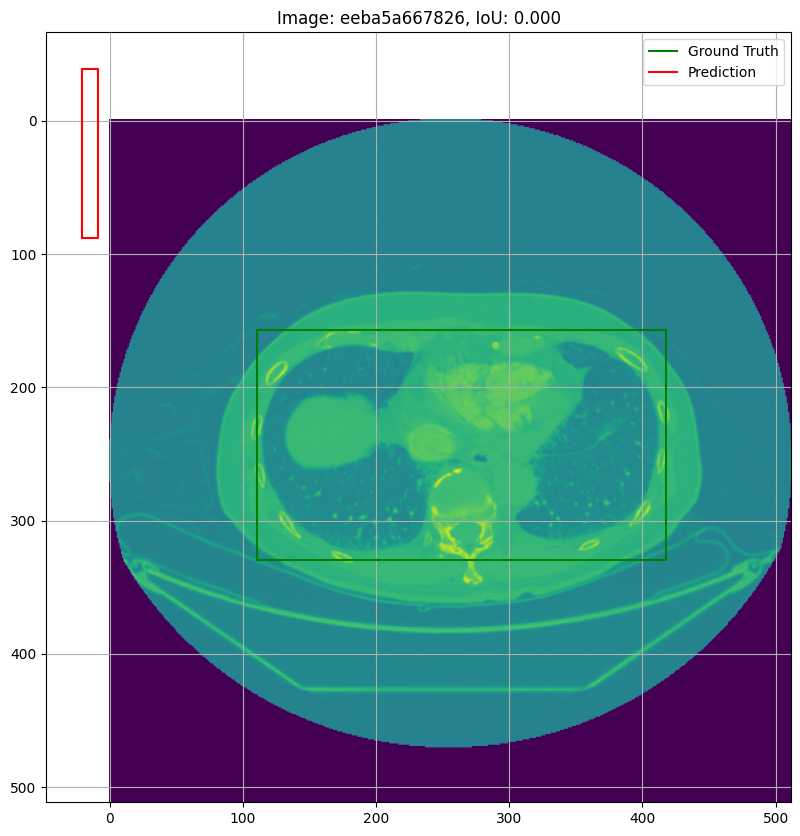

  0%|          | 1/4656 [00:01<2:19:41,  1.80s/it]


Model input stats for 9fbfe96e80e2:
Input tensor shape: torch.Size([1, 3, 512, 512])
Input range: [0.000, 1.000]

Debug for image 9fbfe96e80e2:
Predicted bbox: [-0.04903815  0.17235783 -0.0274377  -0.06207037]
Ground truth bbox: [0.209023, 0.302773, 0.810508, 0.654258]
IoU: 0.0
Predictions in valid range [0,1]: False
Ground truth in valid range [0,1]: True
Image shape: (512, 512)
Image range: [0.000, 1.000]


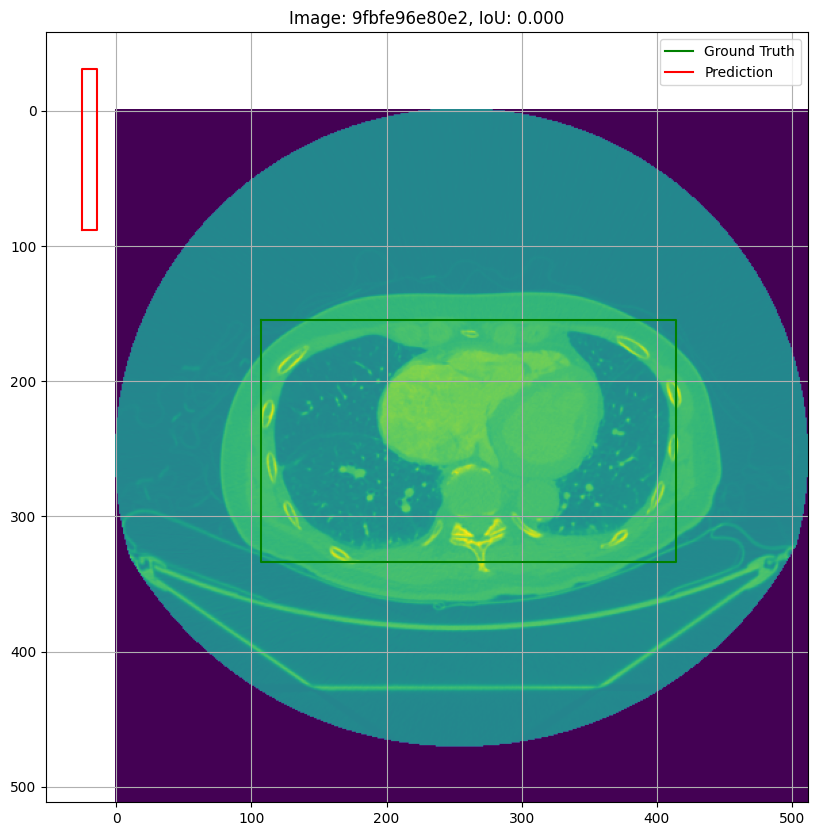

  0%|          | 2/4656 [00:02<1:23:36,  1.08s/it]


Model input stats for 9fbfe96e80e2:
Input tensor shape: torch.Size([1, 3, 512, 512])
Input range: [0.000, 1.000]

Debug for image 9fbfe96e80e2:
Predicted bbox: [-0.04903815  0.17235783 -0.0274377  -0.06207037]
Ground truth bbox: [0.209023, 0.302773, 0.810508, 0.654258]
IoU: 0.0
Predictions in valid range [0,1]: False
Ground truth in valid range [0,1]: True
Image shape: (512, 512)
Image range: [0.000, 1.000]


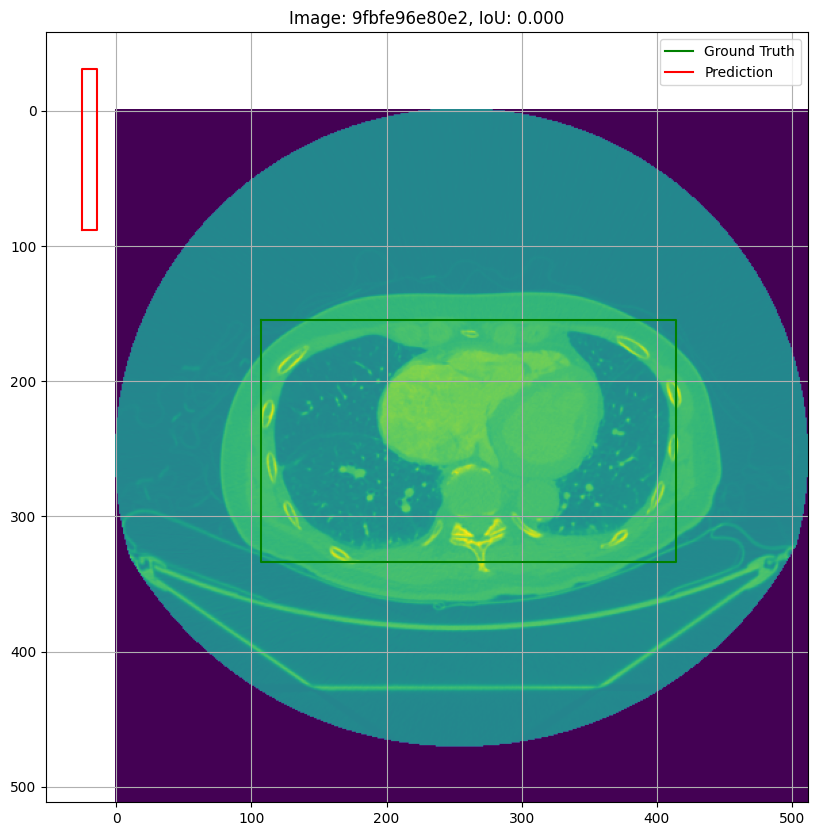

 10%|▉         | 461/4656 [02:58<23:38,  2.96it/s]  

In [ ]:
def debug_prediction(image_id, image, pred_bbox, gt_bbox, iou):
    """Debug a single prediction"""
    print(f"\nDebug for image {image_id}:")
    print(f"Predicted bbox: {pred_bbox}")
    print(f"Ground truth bbox: {gt_bbox}")
    print(f"IoU: {iou}")
    
    # Check if predictions are in valid range
    pred_valid = all(0 <= x <= 1 for x in pred_bbox)
    gt_valid = all(0 <= x <= 1 for x in gt_bbox)
    print(f"Predictions in valid range [0,1]: {pred_valid}")
    print(f"Ground truth in valid range [0,1]: {gt_valid}")
    
    # Check image
    print(f"Image shape: {image.shape}")
    print(f"Image range: [{image.min():.3f}, {image.max():.3f}]")
    
    # Visualize the prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Draw ground truth box in green
    h, w = image.shape[:2]
    gt_x1, gt_y1, gt_x2, gt_y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                                  for i, coord in enumerate(gt_bbox)]
    plt.plot([gt_x1, gt_x2, gt_x2, gt_x1, gt_x1], 
             [gt_y1, gt_y1, gt_y2, gt_y2, gt_y1], 'g-', label='Ground Truth')
    
    # Draw predicted box in red
    pred_x1, pred_y1, pred_x2, pred_y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                                         for i, coord in enumerate(pred_bbox)]
    plt.plot([pred_x1, pred_x2, pred_x2, pred_x1, pred_x1],
             [pred_y1, pred_y1, pred_y2, pred_y2, pred_y1], 'r-', label='Prediction')
    
    plt.legend()
    plt.title(f'Image: {image_id}, IoU: {iou:.3f}')
    plt.show()

def evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device):
    """Evaluate model with debugging"""
    print("\nStarting evaluation...")
    model.eval()
    results = []
    ious = []
    errors = 0
    max_errors = 5
    debug_samples = 3  # Number of samples to debug
    
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Construct path
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                if not os.path.exists(dcm_path):
                    errors += 1
                    if errors <= max_errors:
                        print(f"\nFile not found: {dcm_path}")
                    continue
                
                # Read and preprocess image
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                
                # Window the image for better contrast
                image = (image - np.min(image)) / (np.max(image) - np.min(image))
                image = cv2.resize(image, (Config.image_size, Config.image_size))
                
                # Create 3-channel image
                image_3ch = np.stack([image] * 3, axis=2)
                
                # Convert to tensor
                x = torch.from_numpy(image_3ch.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Debug model input
                if len(results) < debug_samples:
                    print(f"\nModel input stats for {image_id}:")
                    print(f"Input tensor shape: {x.shape}")
                    print(f"Input range: [{x.min().item():.3f}, {x.max().item():.3f}]")
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                
                # Get ground truth and compute IoU
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou,
                    'image': image  # Save image for debugging
                })
                ious.append(iou)
                
                # Debug first few predictions
                if len(results) <= debug_samples:
                    debug_prediction(image_id, image, pred_bbox, gt_bbox, iou)
                
            except Exception as e:
                errors += 1
                if errors <= max_errors:
                    print(f"\nError processing image {image_id}: {str(e)}")
                    import traceback
                    print(traceback.format_exc())
    
    print(f"\nProcessing complete:")
    print(f"Total images attempted: {len(image_list_valid)}")
    print(f"Successfully processed: {len(results)}")
    print(f"Errors: {errors}")
    
    if not results:
        return None, None
    
    return results, np.array(ious)

# Run evaluation with debugging
results, ious = evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device)

if results is not None and len(results) > 0:
    # Analyze predictions
    print("\nPrediction Analysis:")
    pred_bboxes = np.array([r['pred_bbox'] for r in results])
    gt_bboxes = np.array([r['gt_bbox'] for r in results])
    
    print("\nPrediction Statistics:")
    print(f"Mean prediction: {pred_bboxes.mean(axis=0)}")
    print(f"Std prediction: {pred_bboxes.std(axis=0)}")
    print(f"Min prediction: {pred_bboxes.min(axis=0)}")
    print(f"Max prediction: {pred_bboxes.max(axis=0)}")
    
    print("\nGround Truth Statistics:")
    print(f"Mean ground truth: {gt_bboxes.mean(axis=0)}")
    print(f"Std ground truth: {gt_bboxes.std(axis=0)}")
    print(f"Min ground truth: {gt_bboxes.min(axis=0)}")
    print(f"Max ground truth: {gt_bboxes.max(axis=0)}")